In [1]:
import stream_analysis as sa 
import gcs 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import h5py

In [2]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "serif"],
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [3]:
def grab_valid_fnames(GCname, montecarlokey, NPs, MASS_INDEX, RADIUS_INDEX, potential_env, internal_dynamics):
    valid_NPs=[]
    fnames=[]
    for i in range(len(NPs)):
        fname = gcs.path_handler.StreamMassRadius(
            GCname=GCname,
            NP=NPs[i],
            potential_env=potential_env,
            internal_dynamics=internal_dynamics,
            montecarlokey=montecarlokey,
            Mass=MASS_INDEX,
            radius=RADIUS_INDEX,)
        if os.path.exists(fname):
            fnames.append(fname)
            valid_NPs.append(NPs[i])
        else:
            print("file does not exist",fname)
    valid_NPs=np.array(valid_NPs)
    return fnames,valid_NPs

In [4]:
def stack_phase_space(fnames,NPs):
    """ assumes all fnames are valid files of the same format 
    """
    # set the indicies
    cummulative_NPs = np.cumsum(NPs)
    cummulative_NPs = np.insert(cummulative_NPs, 0, 0)
    # initiate the output arrays 
    phase_space = np.zeros((6,NPs.sum()))
    tesc=np.zeros(NPs.sum())
    for i in range(len(fnames)):
        with h5py.File(fnames[i],"r") as f:
            phase_space[:,cummulative_NPs[i]:cummulative_NPs[i+1]] = f["phase_space"][:]
            tesc[cummulative_NPs[i]:cummulative_NPs[i+1]] = f['tesc'][:]
    return phase_space, tesc

In [5]:
def prepare_fig(figsize=(8.25-2, 2)):
    fig=plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(2, 2, figure=fig,width_ratios=[1, 1/50], height_ratios=[1, 1],hspace=0, wspace=0)
    cax = fig.add_subplot(gs[:, 1])
    axes = []
    for i in range(2):
        axes.append(fig.add_subplot(gs[i, 0]))
    return fig, axes, cax

In [6]:
# plot params 
xlims=[-12,12]
ylims=[-0.5,0.5]
cmap = mpl.cm.rainbow
vmax=1e2
vmin=1

In [34]:
### DATA PARAMS 

GCname = "Pal5"
NP = 9100
potential_env = "pouliasis2017pii-GCNBody"
internal_dynamics = "isotropic-plummer_mass_radius_grid"
montecarlokey = "monte-carlo-009"
PerturberName = "NGC7078"
radiusIndex = 4
massIndex = 0
massIndex2 = 2

# get the particle counts per file
start = 9100
stop = 10000
step = 100
append = 4500
NPs = np.arange(start, stop+step, step)
NPs = np.append(NPs, append)

In [26]:
# get the host orbit 
pathorbit=gcs.path_handler.GC_orbits(potential_env,GCname)
tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=gcs.extractors.GCOrbits.extract_whole_orbit(pathorbit,montecarlokey)
# now chop the orbit down 
tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=sa.tailCoordinates.filter_orbit_by_dynamical_time(tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,time_of_interest=0,nDynTimes=2.5)

In [27]:
# extract all the phase space data
fnames,validNPS=grab_valid_fnames(GCname, montecarlokey, NPs, massIndex, radiusIndex, potential_env, internal_dynamics)
phase_space, tesc=stack_phase_space(fnames,validNPS)
# now put it into tail coordinates
xp,yp,zp,vxp,vyp,vzp,_=sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(
    phase_space[0],phase_space[1],phase_space[2],
    phase_space[3],phase_space[4],phase_space[5],
    tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,
    t0=0,
)
X0,Y0,H0=sa.plotters.binned_density.short_cut(validNPS.sum(), xp, yp,xlims=xlims,ylims=ylims)
X0,Y0,H0=sa.plotters.binned_density.order_by_density(X0,Y0,H0)

In [35]:
# get the second mass index
fnames,validNPS=grab_valid_fnames(GCname, montecarlokey, NPs, massIndex2, radiusIndex, potential_env, internal_dynamics)
phase_space, tesc=stack_phase_space(fnames,validNPS)
# now put it into tail coordinates
xp,yp,zp,vxp,vyp,vzp,_=sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(
    phase_space[0],phase_space[1],phase_space[2],
    phase_space[3],phase_space[4],phase_space[5],
    tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,
    t0=0,
)
X1,Y1,H1=sa.plotters.binned_density.short_cut(validNPS.sum(), xp, yp,xlims=xlims,ylims=ylims)
X1,Y1,H1=sa.plotters.binned_density.order_by_density(X1,Y1,H1)

In [36]:
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

In [37]:
AXES0={
    "xlim":xlims,
    "ylim":ylims,
    "xticks":[],
    "yticks":[0,0.5],
}
AXES1={
    "xlim":xlims,
    "ylim":ylims,
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "yticks":[-0.5,0,0.5],
    "xticks":np.arange(-12,12+3,3),
}
SCAT = {
    "s":0.1,
    "cmap":cmap,
    "alpha":0.9,
    "norm":norm,
}

In [38]:
myfile=h5py.File(fnames[0],"r")

In [39]:
for key in myfile.attrs.keys():
    print("{:24s}".format(key),myfile.attrs[key])

GCname                   Pal5
GCnames                  ['NGC5272' 'NGC104' 'NGC2808' 'NGC7078' 'NGC7099' 'NGC1904' 'NGC6341'
 'NGC6356']
GCorbits_potential       pouliasis2017pii-GCNBody
HALF_MASS_RADIUS         0.029999999999999995
MASS                     39810.71705534969
MWpotential              pouliasis2017pii
NP                       9100
NSKIP                    10000
README                   The reviewer wanted a more massive Palomar 5. This script is the answer to that request. The script is a copy of the one in recipees/execute_GCNBody_Palomar5.py with the only difference being the mass of the Palomar 5 cluster. The mass of the Palomar 5 cluster is set to XXX Msun.
T                        -5000000000.0
author                   Salvatore Ferrone
author_affiliation       Sapienza University of Rome AND the Paris Observatory
author_email             salvatore.ferrone@uniroma1.it
computation_time         30352
date                     ['2025-03-06 04:53:06']
description        

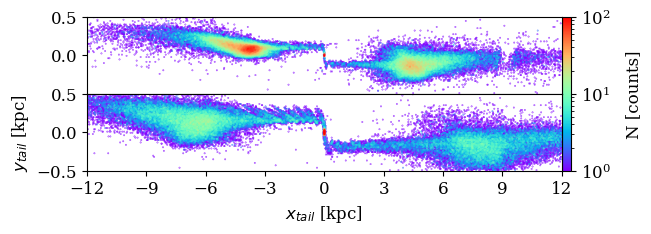

In [40]:
fig,axes,cax=prepare_fig()
axes[0].scatter(X0,Y0,c=H0,**SCAT)
axes[0].set(**AXES0)
axes[1].scatter(X1,Y1,c=H1,**SCAT)
axes[1].set(**AXES1);
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("N [counts]", rotation=90, labelpad=10)

In [52]:
# do the weighed histogram
Nbins = int(np.sqrt(NPs.sum()))
edges = np.linspace(xlims[0], xlims[1], Nbins)
centers=0.5*(edges[1:]+edges[:-1])
counts0,_=np.histogram(X0,weights=H0,bins=edges)
counts1,_=np.histogram(X1,weights=H1,bins=edges)

(-12.0, 12.0)

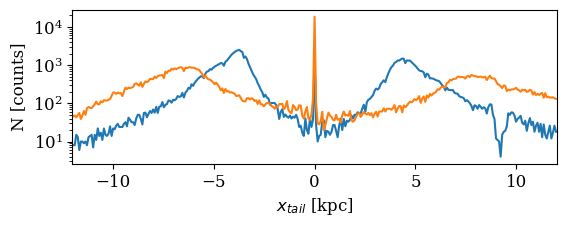

In [56]:
fig,axis=plt.subplots(figsize=(8.25-2, 2))
axis.plot(centers,counts0, label="mass index 0", color="C0")
axis.plot(centers,counts1, label="mass index 2", color="C1")
axis.set_yscale("log")
axis.set_xlabel("$x_{tail}$ [kpc]")
axis.set_ylabel("N [counts]")
axis.set_xlim(xlims)

In [ ]:
# alright. Nice. 